In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_4DLorenz.recursive_LSTM_PostMeanScore_4DLorenz_T256_H05_tl_110data_StbleTgt import \
    get_config
#from configs.RecursiveVPSDE.LSTM_4DLorenz.recursive_LSTM_PostMeanScore_4DLorenz_10FC_T256_H05_tl_110data_StbleTgt import get_config

In [2]:
config = get_config()
deltaT = config.deltaT
print(config.scoreNet_trained_path)

/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_ST_0100FTh_PM_TSM_2LFac_4DLnz_750e-01FConst_VPSDE_model_H50e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20e+01_BetaMin00e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_LSTM_H20_Nly1_tl110


In [3]:
def plot_ewma_losses(epochs, losses):
    start_idx = 00
    def compute_ema(loss_tensor, beta):
        ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
        ema_values[0] = loss_tensor[0]  # First value stays the same

        for i in range(1, len(loss_tensor)):
            ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

        return ema_values
    # Define EMA decay rates
    beta_short = 0.9   # Short-term trend (reacts quickly)
    beta_long = 0.99   # Long-term trend (smoother)

    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    plt.scatter(epochs[start_idx:], (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.scatter(epochs[start_idx:], (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

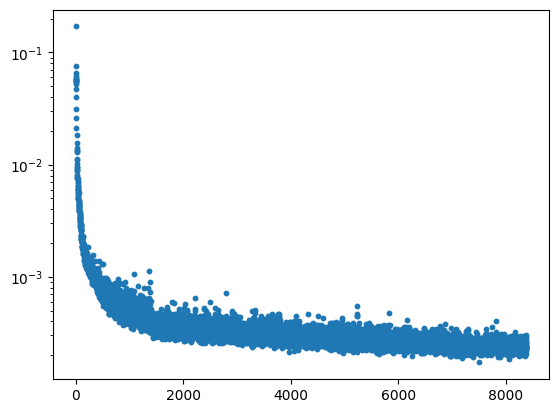

8381

In [4]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.scatter(Nepochs_losses,  losses, s=10)
plt.yscale("log")
plt.show()
plt.close()
Nepochs_losses[-1]

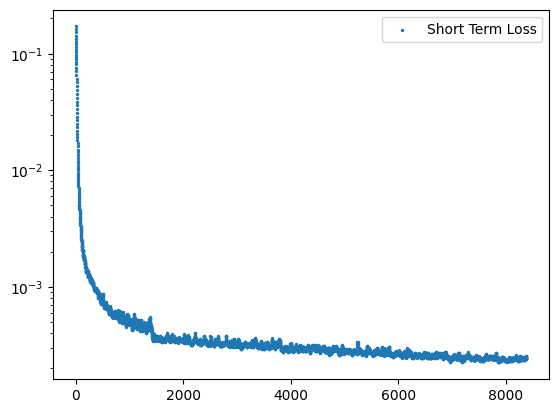

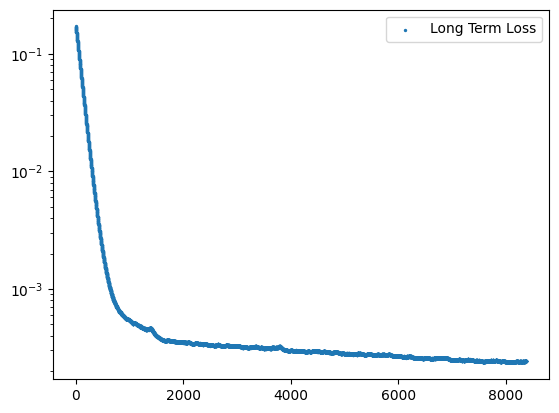

In [5]:
plot_ewma_losses(epochs=Nepochs_losses, losses=losses)

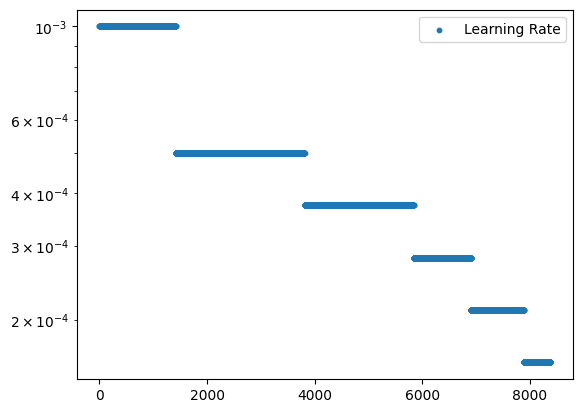

0


In [6]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss_LR", 'rb') as f:
        LRs = (np.array(pickle.load(f)).astype(float))
start = 0#935
end = -1#935+152
plt.scatter(Nepochs_losses[start:end],  LRs[start:end], s=10, label="Learning Rate")
plt.yscale("log")
plt.legend()
plt.show()
plt.close()
print(end-start+1)

In [7]:
def get_drift_files(config, ts_type_str):
    ts_type = f"ST_{config.feat_thresh:.3f}FTh_{config.ndims}DLorenz".replace(".", "")
    include =  (f"_{1}NDT_{config.loss_factor}LFac_BetaMax{config.beta_max:.1e}_{round(config.forcing_const,3)}FConst").replace(
            ".", "")
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_dir):
        if "LSTM" in file and ts_type in file and include in file:
            if "OOSDriftTrack" in file and "true" in file:
                driftoostrack_true_files.append(root_dir+file)
            elif "OOSDriftTrack" in file and "local" in file:
                driftoostrack_local_files.append(root_dir+file)
    assert len(driftoostrack_true_files)>0, "No oos drift track files found"
    assert len(driftoostrack_local_files)>0, "No oos drift track files found"
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    return driftoostrack_true_files, driftoostrack_local_files, Nepochs_track

In [8]:
ts_type_str = f"{round(config.forcing_const, 3)}FConst".replace(".", "")
driftoostrack_true_files, driftoostrack_local_files, Nepochs_track = get_drift_files(config=config, ts_type_str=ts_type_str)

In [9]:
drift_track_rmses = {}
epochs_iter = Nepochs_track
Nepochs_keep = []
for Nepoch, true, local in zip(*[epochs_iter, driftoostrack_true_files, driftoostrack_local_files]):
    try:
        all_true_states = np.load(true)/np.sqrt(config.deltaT)
        all_local_states= np.load(local)/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean((all_local_errors), axis=0)
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
        Nepochs_keep.append(Nepoch)
    except (FileNotFoundError, ValueError) as e:
        print(e)
        continue
Nepochs_track = Nepochs_keep
drift_track_rmses

{184: 0.0017054227890219548,
 186: 0.0019447419548275595,
 188: 0.0019207227332480657,
 190: 0.0017080684745254063,
 192: 0.0018490568625979362,
 194: 0.0017510128201578986,
 196: 0.0017636825247894085,
 198: 0.001726191099291017,
 200: 0.0017024523071058363,
 202: 0.001909724018889491,
 204: 0.0018112828913294354,
 206: 0.0018576689319601055,
 208: 0.0016578837542855739,
 210: 0.001727181662114989,
 212: 0.0018111475755758666,
 214: 0.0017403494005115692,
 216: 0.0017837415983466178,
 218: 0.0017480190529680778,
 220: 0.0019186214457760805,
 222: 0.001691705081901643,
 224: 0.0016839217639857435,
 226: 0.0021985341479095286,
 228: 0.0016742565367300923,
 230: 0.001708323697095252,
 232: 0.0018313072670490445,
 234: 0.0019636349608139277,
 236: 0.0017577912629632077,
 238: 0.0017147294915618178,
 240: 0.003266316197697219,
 242: 0.0018607427283272766,
 244: 0.001631438125146974,
 246: 0.0017210705768248315,
 248: 0.0025913255454261524,
 250: 0.0017013974888778244,
 252: 0.0017154912487

In [10]:
common_epochs = np.intersect1d(Nepochs_losses, Nepochs_track)
common_epochs = np.intersect1d(common_epochs, np.arange(100, 10000))
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs]
red_losses = losses[losses_idx]
track_idx = [np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs]
track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]

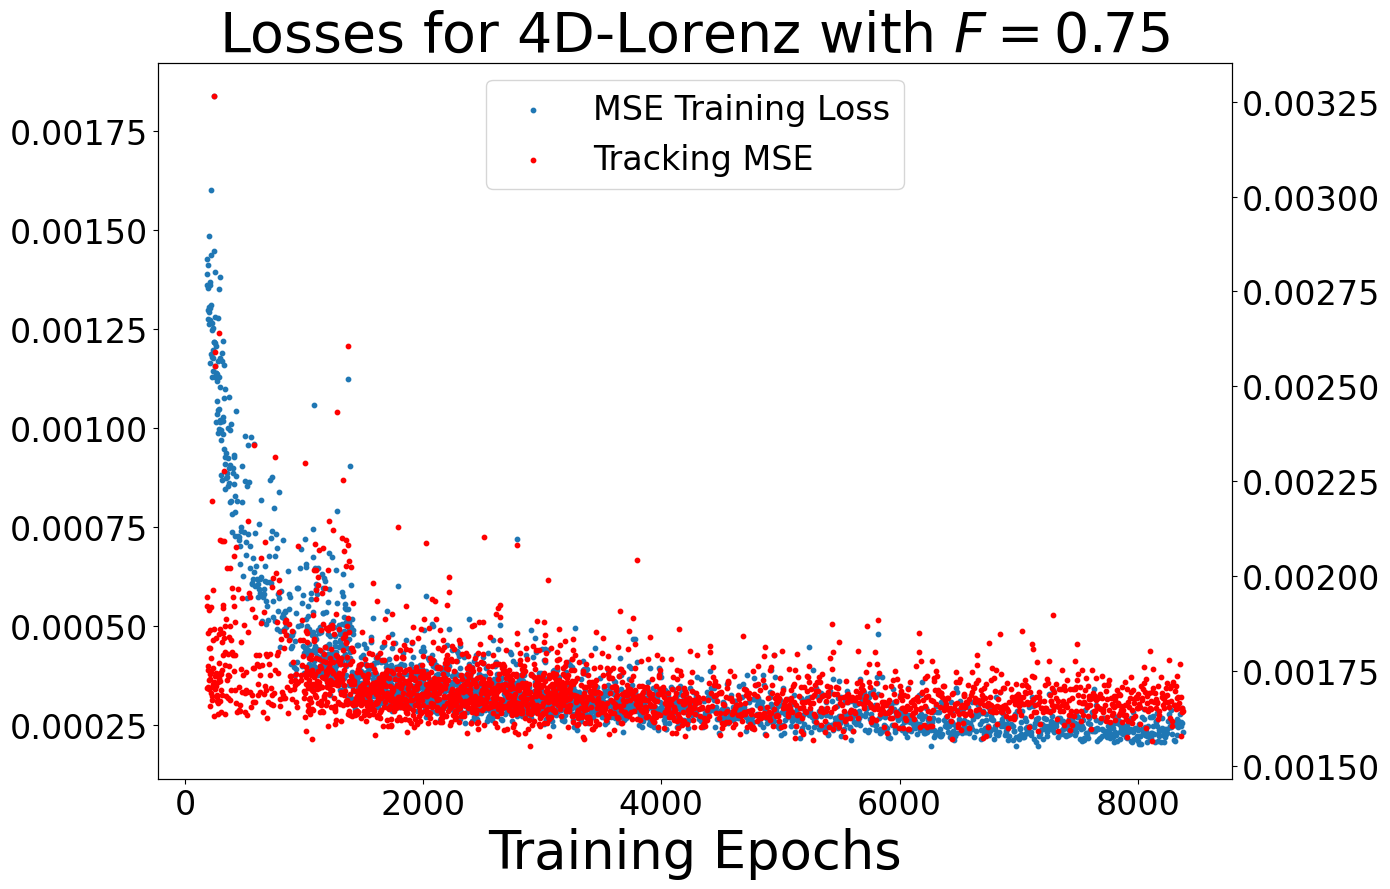

0.001270809438844901

In [11]:
toSave = True
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="MSE Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses, s=10, color="red",label="Tracking MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(rf"Losses for {config.ndims}D-Lorenz with $F = {config.forcing_const}$", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
#ax.set_yscale("log")
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, loc="upper center", fontsize=24)
if toSave:
    plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/f4DLnz_Losses_PM_LSTM_{round(config.forcing_const,3)}FConst").replace(".", "")+".png")
plt.show()
plt.close()
losses[-1]/losses[start_idx]

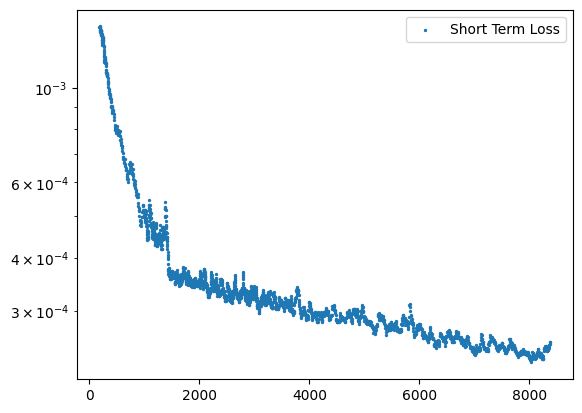

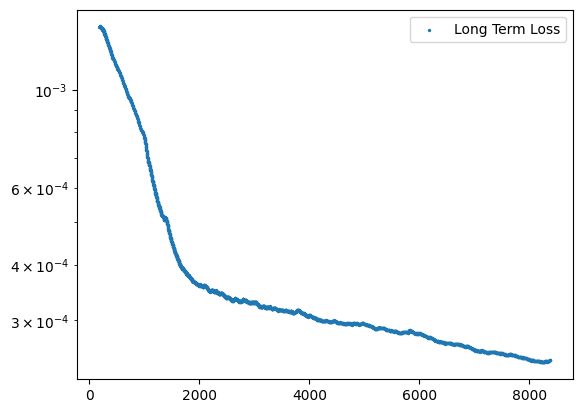

In [12]:
plot_ewma_losses(epochs=common_epochs, losses=red_losses)

0.0016954221511617268 inf


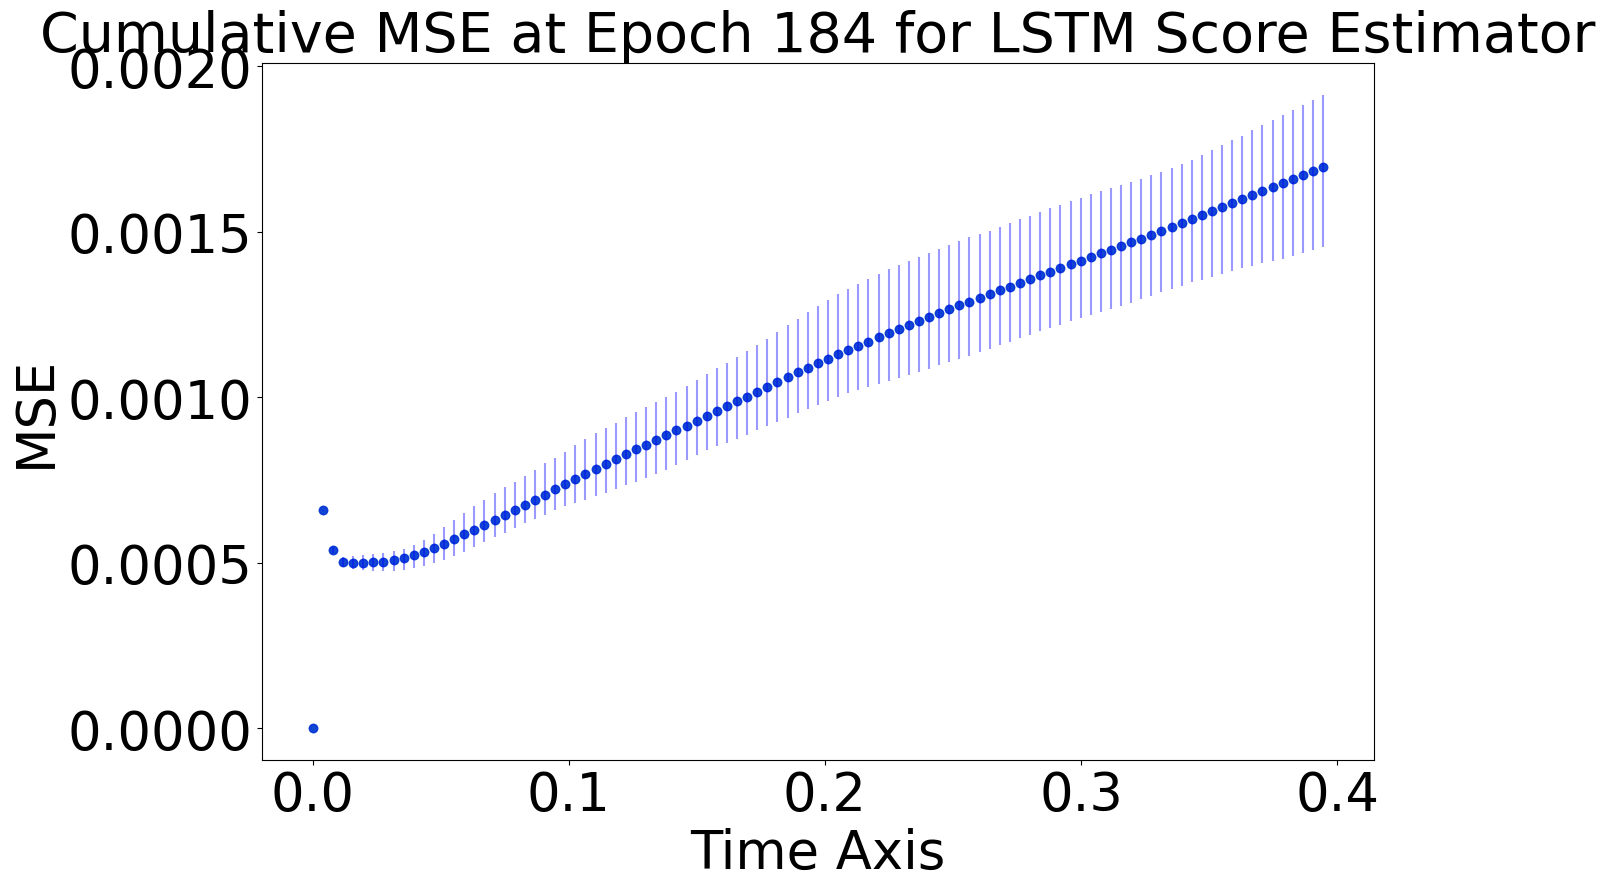

Final time cumulative MSE local-time error 0.0016954221511617268 with final IQR (0.0014534955752346574, 0.0019136279672891405) at Nepoch 184 for 0.75FConst

0.001956297511055449 0.0016954221511617268
0.001897564093506699 0.0016954221511617268
0.0016803384286978855 0.0016954221511617268


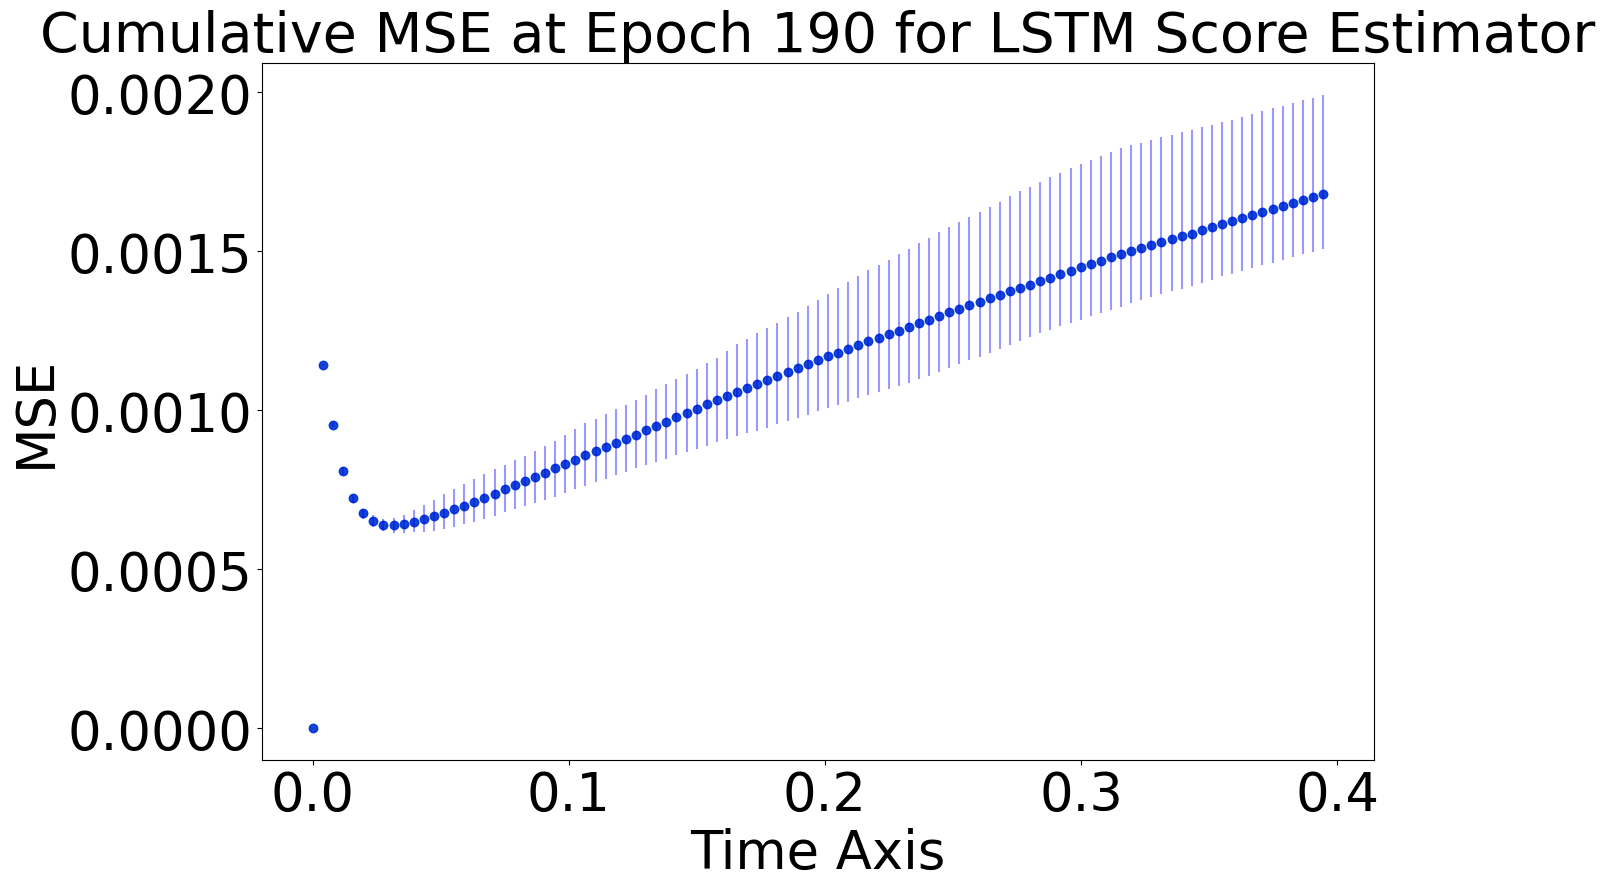

Final time cumulative MSE local-time error 0.0016803384286978855 with final IQR (0.0015085398699893353, 0.0019927528461668766) at Nepoch 190 for 0.75FConst

0.001833193659497125 0.0016803384286978855
0.0017483997524762338 0.0016803384286978855
0.0017655948586660529 0.0016803384286978855
0.0017189699596268544 0.0016803384286978855
0.0016973522324386806 0.0016803384286978855
0.0019166579622793552 0.0016803384286978855
0.0018063189767847268 0.0016803384286978855
0.001872436179972437 0.0016803384286978855
0.0016576136986514347 0.0016803384286978855


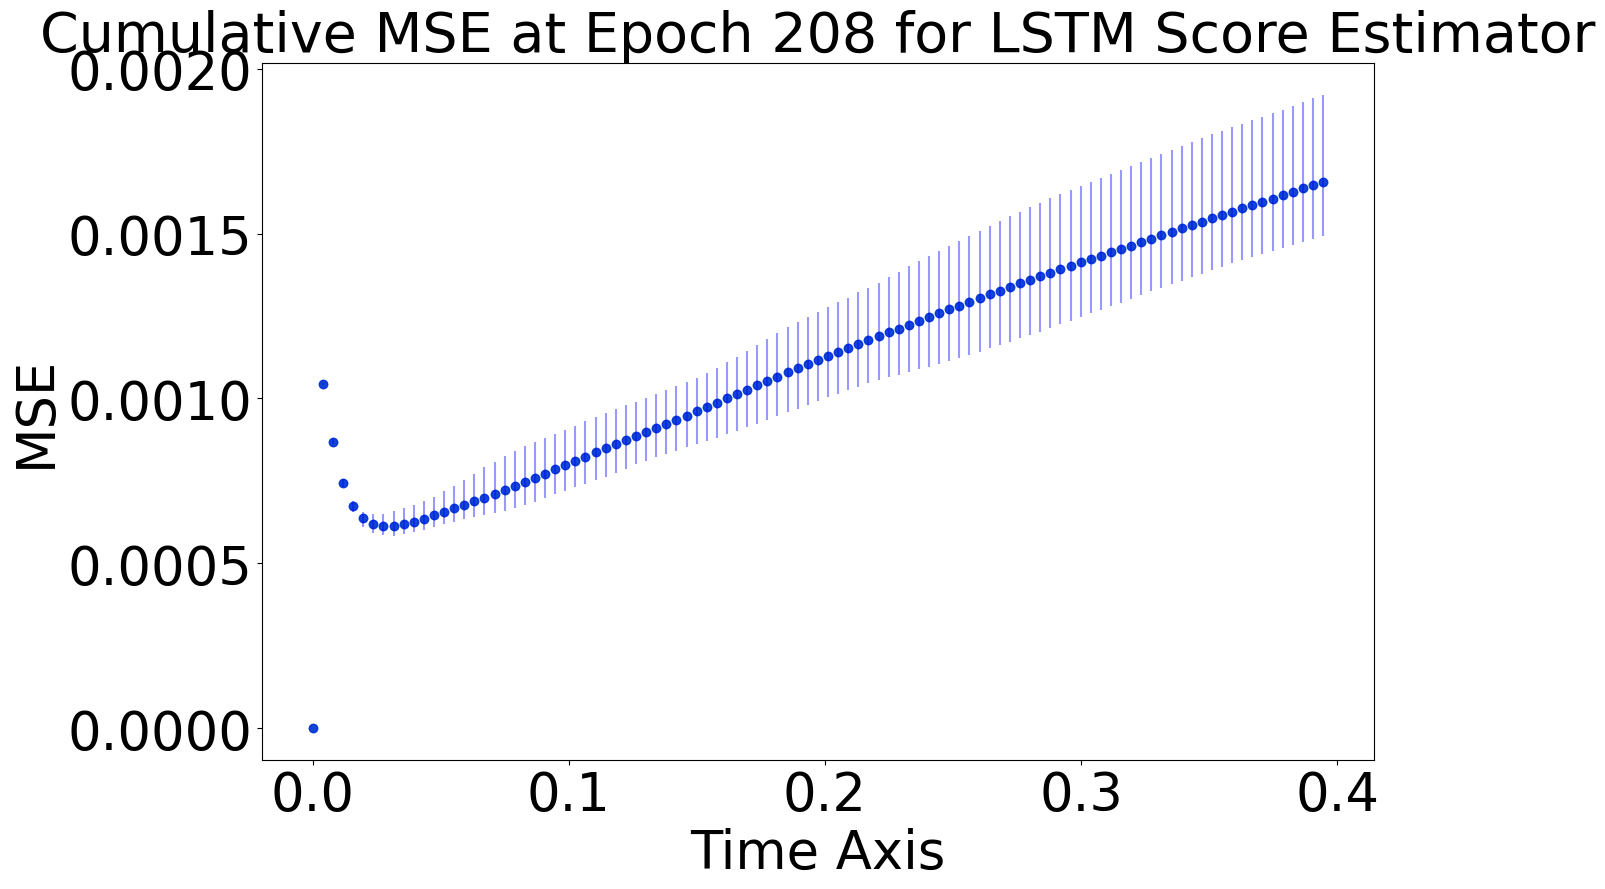

Final time cumulative MSE local-time error 0.0016576136986514347 with final IQR (0.001491571244473307, 0.0019212548513410019) at Nepoch 208 for 0.75FConst

0.0017141547709390815 0.0016576136986514347
0.001812479508853297 0.0016576136986514347
0.0017364330897813262 0.0016576136986514347
0.0017902937710538977 0.0016576136986514347
0.0017406227802087778 0.0016576136986514347
0.0019253646102168867 0.0016576136986514347
0.001680532502643414 0.0016576136986514347
0.001690718262451857 0.0016576136986514347
0.0021843021390458815 0.0016576136986514347
0.0016998250932418026 0.0016576136986514347
0.0017184162624536954 0.0016576136986514347
0.001818683655938678 0.0016576136986514347
0.001959499408116411 0.0016576136986514347
0.0017676052605197685 0.0016576136986514347
0.001716547112354391 0.0016576136986514347
0.0032709756655149714 0.0016576136986514347
0.001865302699087207 0.0016576136986514347
0.001627295906458004 0.0016576136986514347


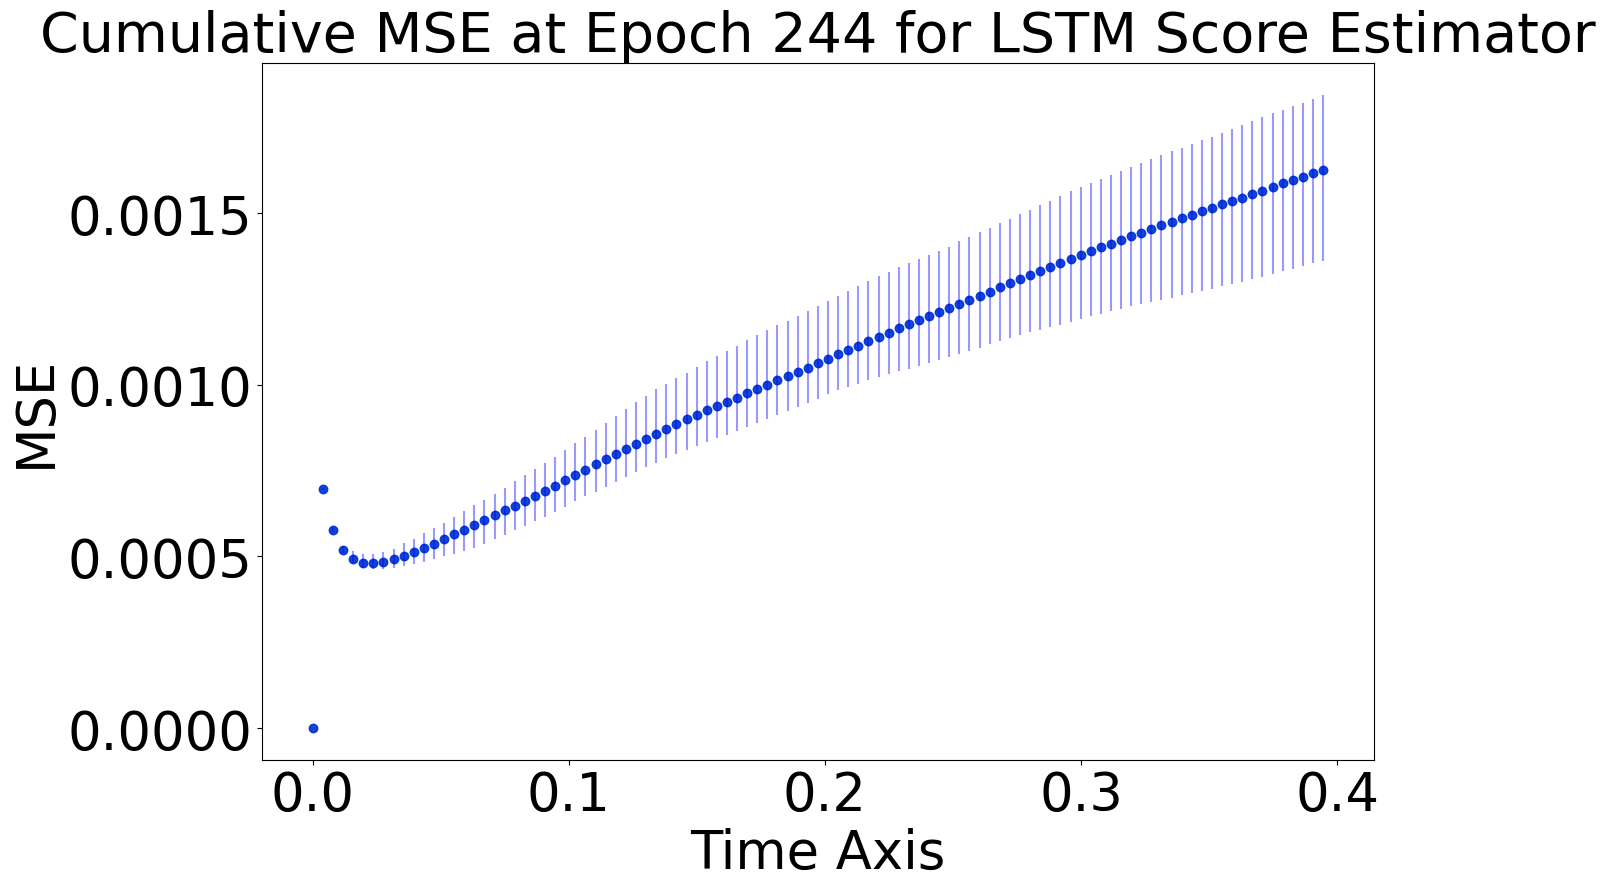

Final time cumulative MSE local-time error 0.001627295906458004 with final IQR (0.0013615878874349678, 0.0018454818501211015) at Nepoch 244 for 0.75FConst

0.0017371677607623298 0.001627295906458004
0.002590210739747335 0.001627295906458004
0.0016986665747021764 0.001627295906458004
0.001719429996438587 0.001627295906458004
0.0025566868556353645 0.001627295906458004
0.001722312627171192 0.001627295906458004
0.001736520188422298 0.001627295906458004
0.0018271180279550005 0.001627295906458004
0.0017479193374366714 0.001627295906458004
0.0017004138166209065 0.001627295906458004
0.0016837484106016624 0.001627295906458004
0.0016790459032804779 0.001627295906458004
0.0016792180532317043 0.001627295906458004
0.0017276458790568402 0.001627295906458004
0.0016324729288232618 0.001627295906458004
0.0016528466893676712 0.001627295906458004
0.001706070823448948 0.001627295906458004
0.001738018670005003 0.001627295906458004
0.002654581035350229 0.001627295906458004
0.0017335139357741274 0.0016272959

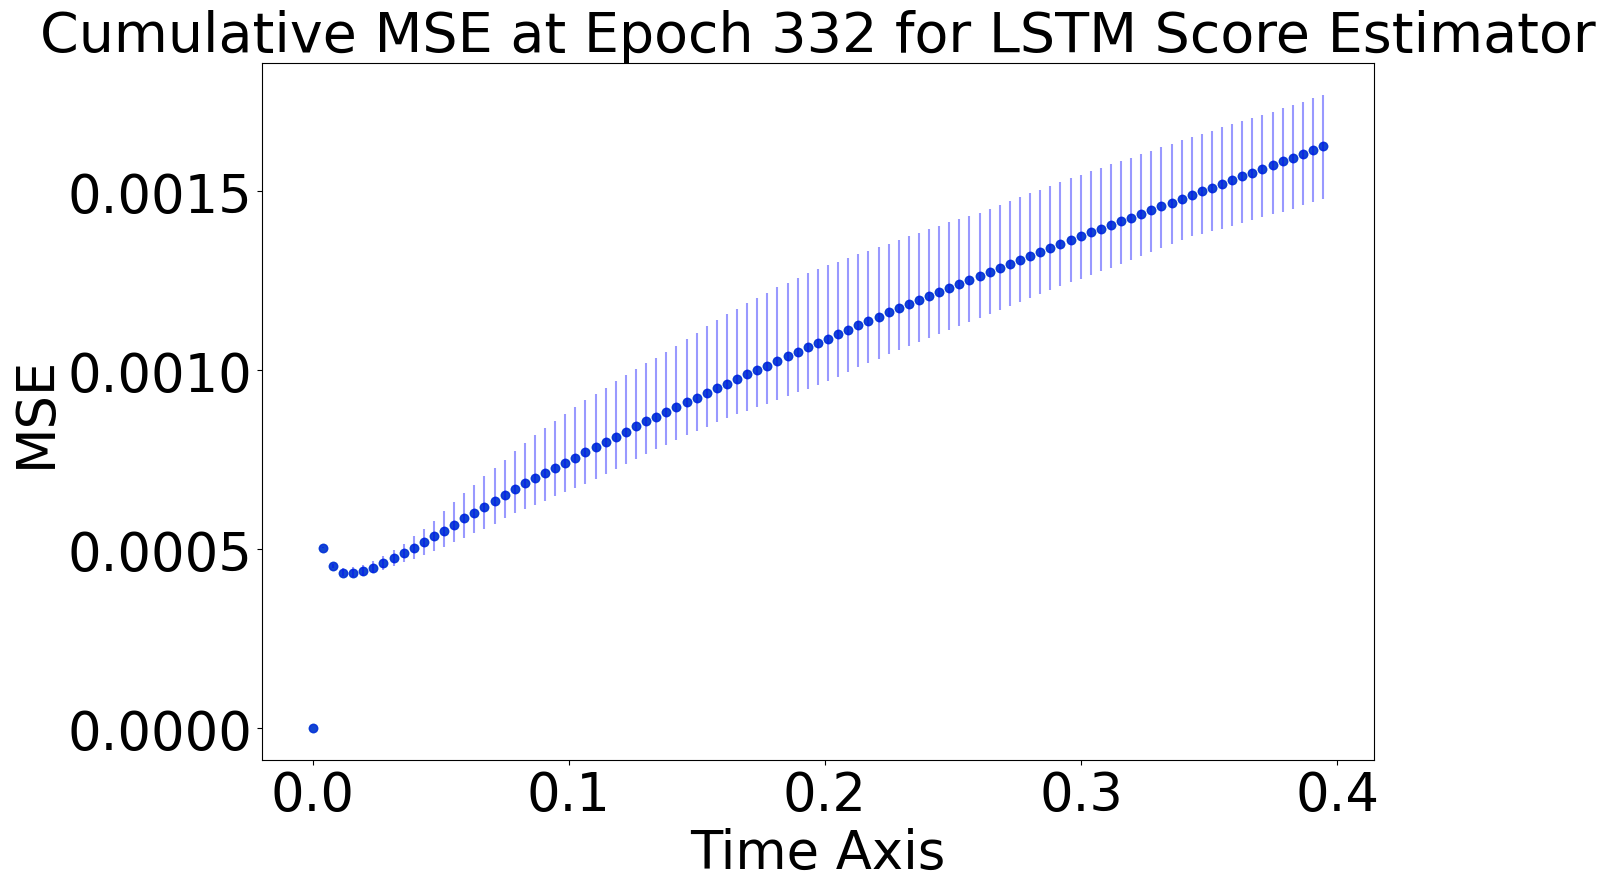

Final time cumulative MSE local-time error 0.0016268373076208293 with final IQR (0.001478941962274649, 0.001769764657997936) at Nepoch 332 for 0.75FConst

0.0017846380394549775 0.0016268373076208293
0.0018592144597702259 0.0016268373076208293
0.0017780114352423891 0.0016268373076208293
0.0016819644194502389 0.0016268373076208293
0.0018763106500300263 0.0016268373076208293
0.0017221230424913736 0.0016268373076208293
0.002002570790506235 0.0016268373076208293
0.001797340347058368 0.0016268373076208293
0.0016700824948506967 0.0016268373076208293
0.0017154271633321246 0.0016268373076208293
0.001834768312267274 0.0016268373076208293
0.001753962658523273 0.0016268373076208293
0.0017665592532552603 0.0016268373076208293
0.0020028576898690285 0.0016268373076208293
0.0018718617786154547 0.0016268373076208293
0.0016686058427676466 0.0016268373076208293
0.0018385766437834944 0.0016268373076208293
0.001703001667399757 0.0016268373076208293
0.0019778542732764 0.0016268373076208293
0.001797081315289

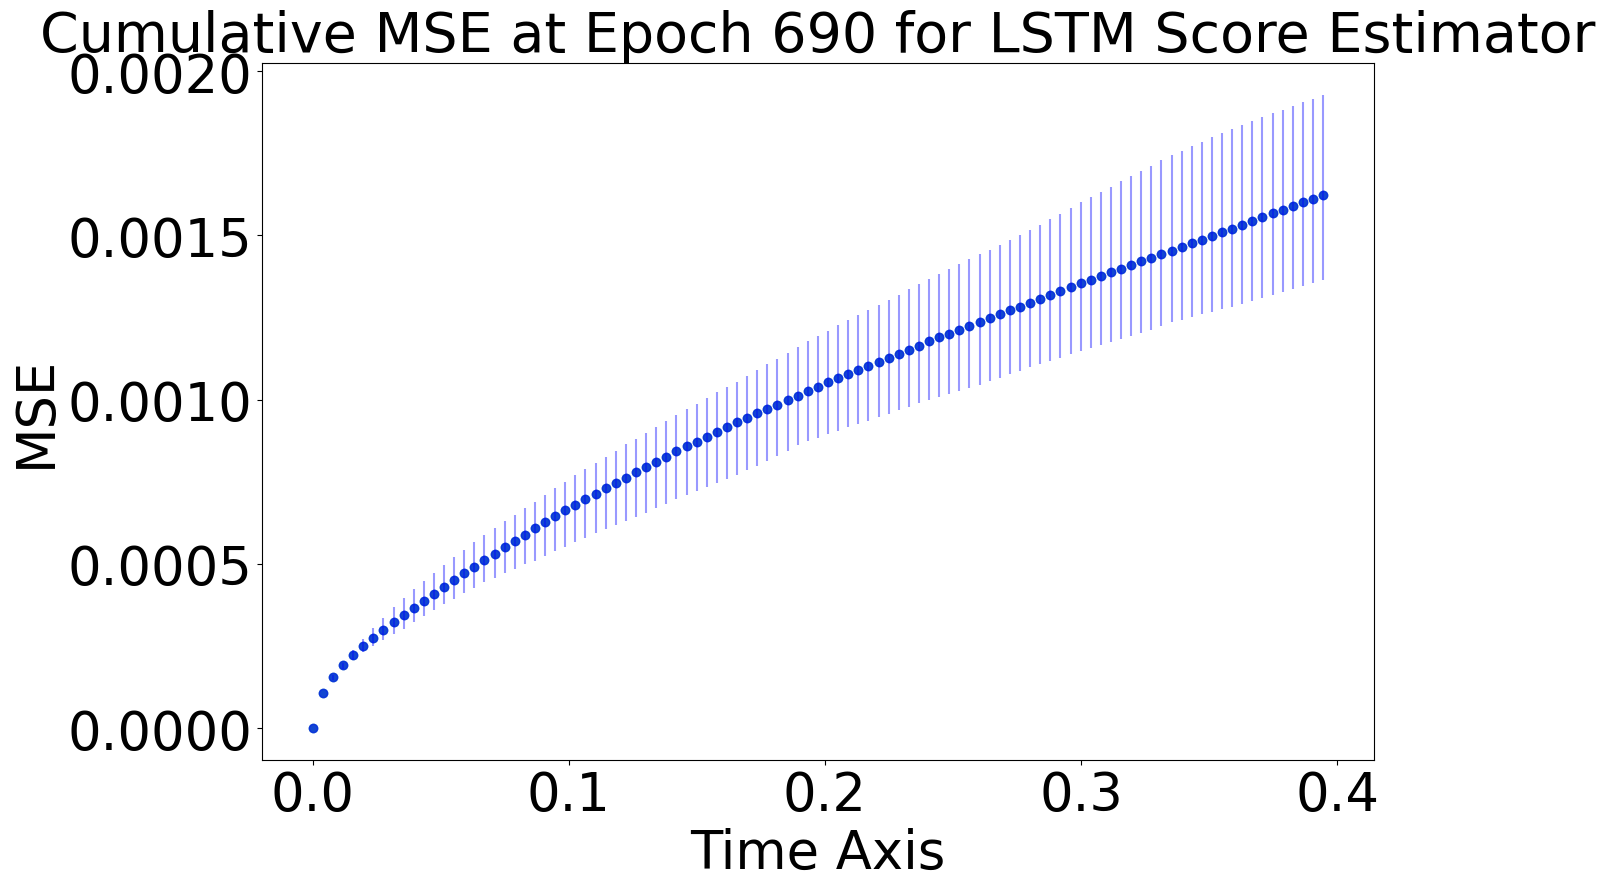

Final time cumulative MSE local-time error 0.001622419518151953 with final IQR (0.001363897181412022, 0.0019288613465036975) at Nepoch 690 for 0.75FConst

0.0017930247814912277 0.001622419518151953
0.001657732727827665 0.001622419518151953
0.0017732034052159351 0.001622419518151953
0.0018021056696981425 0.001622419518151953
0.0017430312361969476 0.001622419518151953
0.0016733231939693011 0.001622419518151953
0.0017149888590768181 0.001622419518151953
0.0016968362385524607 0.001622419518151953
0.0019555999124069726 0.001622419518151953
0.0016749459858225848 0.001622419518151953
0.0019916776099353074 0.001622419518151953
0.001696951428397397 0.001622419518151953
0.0017630553735654751 0.001622419518151953
0.0023041091816292363 0.001622419518151953
0.0019975851841427307 0.001622419518151953
0.0018946352242525536 0.001622419518151953
0.0017771886083067334 0.001622419518151953
0.00175558838213792 0.001622419518151953
0.0018038444151515605 0.001622419518151953
0.0019728944714670063 0.00162241

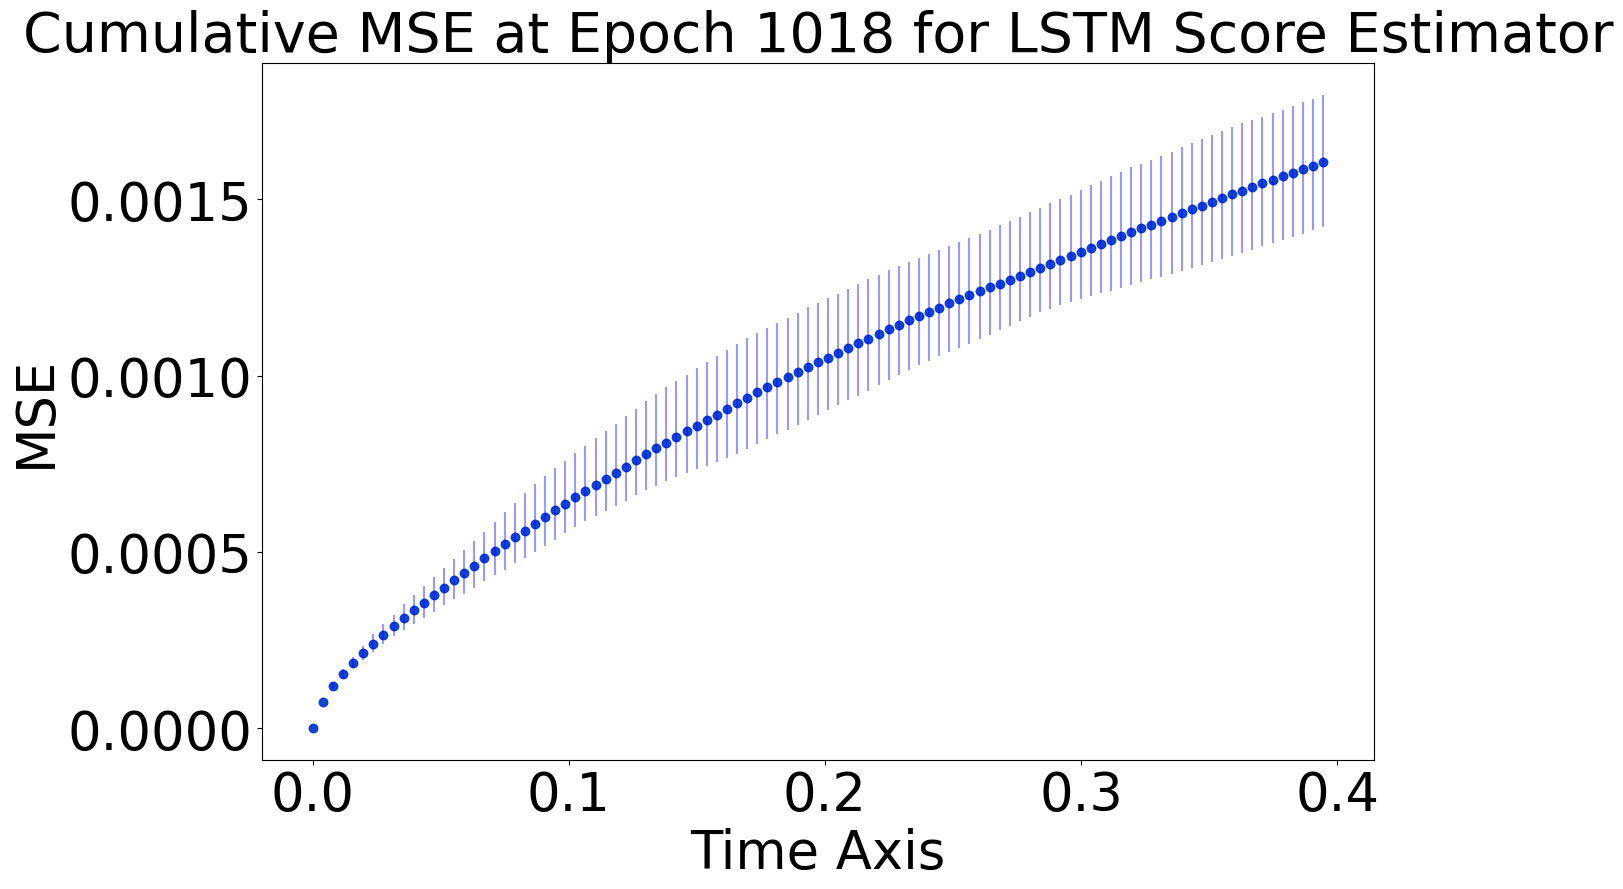

Final time cumulative MSE local-time error 0.0016053567232328797 with final IQR (0.0014219401175531222, 0.0017966815981496384) at Nepoch 1018 for 0.75FConst

0.0018712490757872337 0.0016053567232328797
0.001748405988487703 0.0016053567232328797
0.0018625587241549138 0.0016053567232328797
0.0017325778712410538 0.0016053567232328797
0.0018358143516601446 0.0016053567232328797
0.00172253543341774 0.0016053567232328797
0.0016589211325434687 0.0016053567232328797
0.0016355069094850733 0.0016053567232328797
0.0017398160026836909 0.0016053567232328797
0.001792097762232246 0.0016053567232328797
0.00171719127232963 0.0016053567232328797
0.0016407209826660107 0.0016053567232328797
0.001673134690679849 0.0016053567232328797
0.0016541977949393665 0.0016053567232328797
0.001659275055716745 0.0016053567232328797
0.0016884194165627518 0.0016053567232328797
0.0017073109659263962 0.0016053567232328797
0.0016702609121738753 0.0016053567232328797
0.0017871775262814195 0.0016053567232328797
0.001742343207

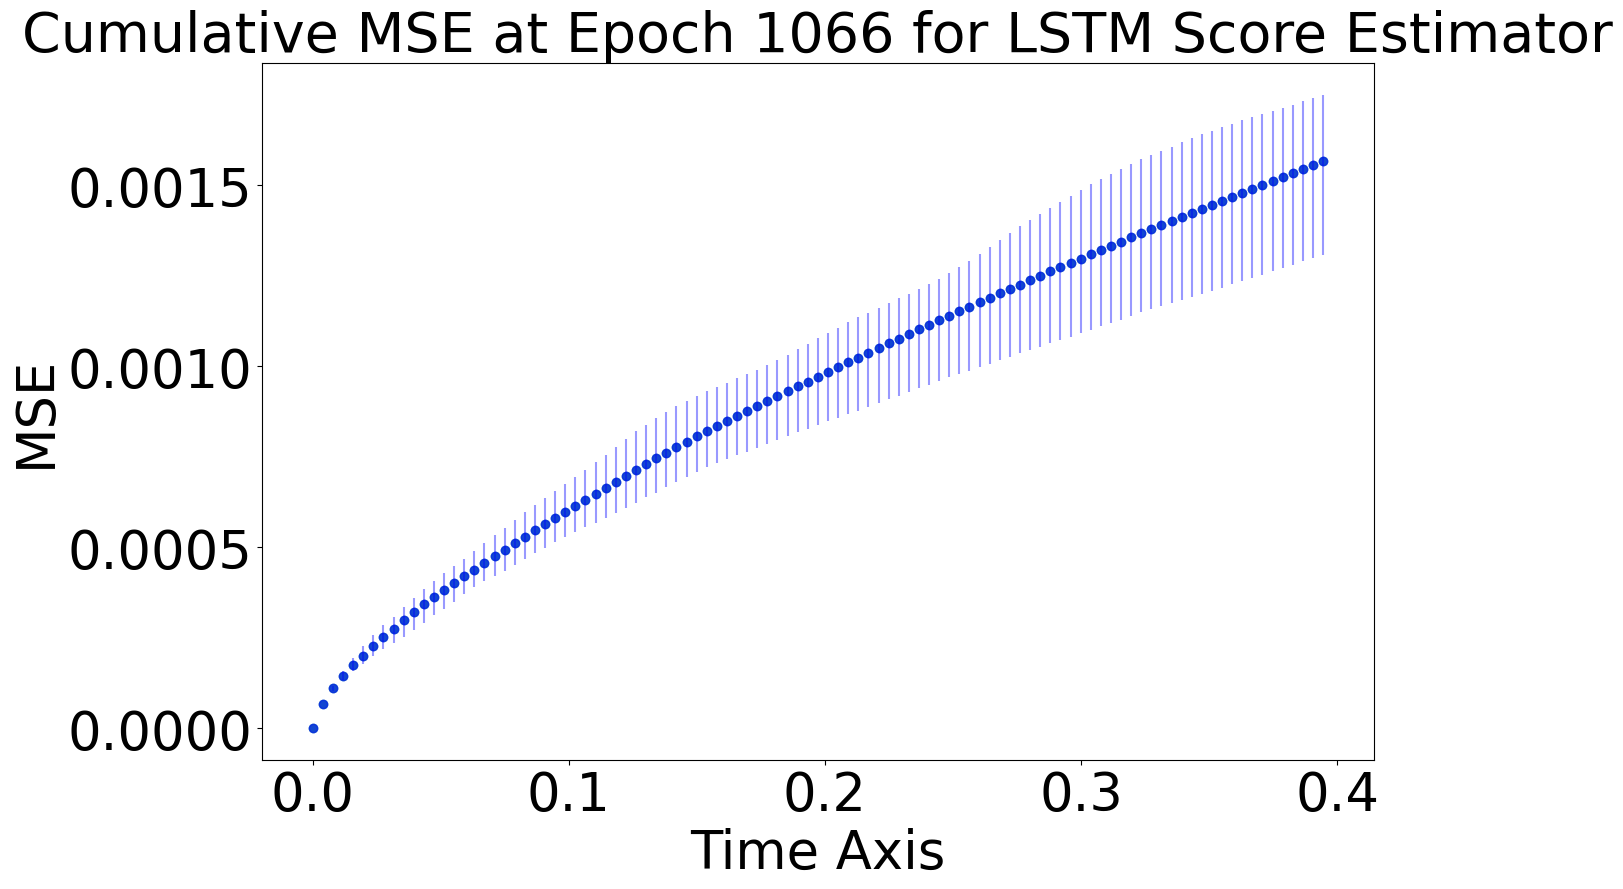

Final time cumulative MSE local-time error 0.001566161154482988 with final IQR (0.0013082992669552409, 0.0017504429168044343) at Nepoch 1066 for 0.75FConst

0.001635444481741111 0.001566161154482988
0.0017579250738868496 0.001566161154482988
0.0016992515910797838 0.001566161154482988
0.0016958658186522326 0.001566161154482988
0.0019110295732630443 0.001566161154482988
0.0016404340891848905 0.001566161154482988
0.0018417120684983987 0.001566161154482988
0.001756098034070644 0.001566161154482988
0.0020255806421496663 0.001566161154482988
0.0018457223462147326 0.001566161154482988
0.001709554295388544 0.001566161154482988
0.001688279738193519 0.001566161154482988
0.0020998680717607163 0.001566161154482988
0.0017510497364489107 0.001566161154482988
0.0019603128139175138 0.001566161154482988
0.0016772808661826633 0.001566161154482988
0.001766749509264972 0.001566161154482988
0.001956512773042425 0.001566161154482988
0.002019765050389829 0.001566161154482988
0.0016861300773843727 0.001566161

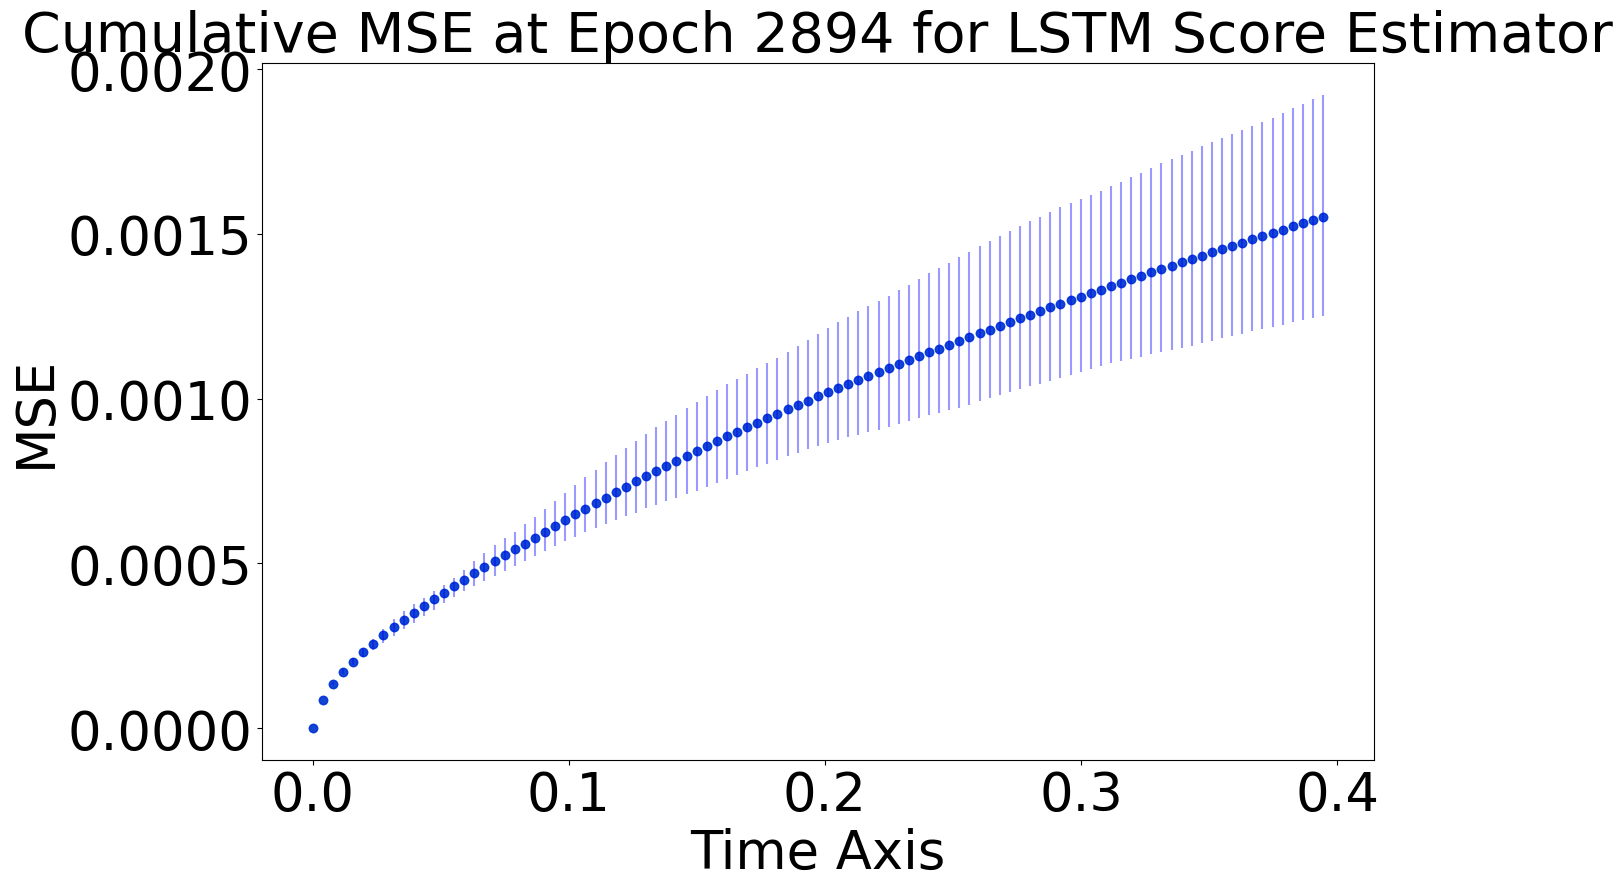

Final time cumulative MSE local-time error 0.0015521120486012656 with final IQR (0.0012510254398847404, 0.0019221223364532085) at Nepoch 2894 for 0.75FConst

0.0016618102029756685 0.0015521120486012656
0.0016955808983158494 0.0015521120486012656
0.001640251318135588 0.0015521120486012656
0.0017495151099032155 0.0015521120486012656
0.0016044514090044698 0.0015521120486012656
0.0016858974283646157 0.0015521120486012656
0.001724099468131928 0.0015521120486012656
0.001635808284972575 0.0015521120486012656
0.0016523288378651423 0.0015521120486012656
0.0016833395033896493 0.0015521120486012656
0.0016782306495006136 0.0015521120486012656
0.0016059791152551752 0.0015521120486012656
0.0016841681247250185 0.0015521120486012656
0.0016723838799192578 0.0015521120486012656
0.001820337836701773 0.0015521120486012656
0.0016529171963224792 0.0015521120486012656
0.0017748448469637607 0.0015521120486012656
0.0016399645422264268 0.0015521120486012656
0.0017349366048487675 0.0015521120486012656
0.00165462

In [13]:
curr_rmse = np.inf#0.0378
toSave = True
for f in zip(*[Nepochs_track, driftoostrack_true_files, driftoostrack_local_files]):
    Nepoch = f[0]
    true = f[1]
    local = f[2]
    try:
        if Nepoch != 2894: raise FileNotFoundError
        all_true_states = np.load(true, allow_pickle=True)[2:]/np.sqrt(config.deltaT)
        all_local_states= np.load(local,allow_pickle=True)[2:]/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean((all_local_errors), axis=0)
        total_local_errors_minq = np.quantile((all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile((all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], curr_rmse)
        if total_local_errors[-1] < curr_rmse:
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(time_steps, total_local_errors)
            #plt.fill_between(time_steps, total_local_errors_minq, total_local_errors_maxq, color="blue", alpha=0.2, label="95% Confidence Band")
            plt.errorbar(time_steps,total_local_errors,yerr=[total_local_errors-total_local_errors_minq, total_local_errors_maxq-total_local_errors],xerr=None, fmt='o', color="blue", alpha=0.4)

            ax.set_title(f"Cumulative MSE at Epoch {Nepoch} for LSTM Score Estimator",fontsize=40)
            ax.set_ylabel("MSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/f4DLnz_OOSDriftTrack_{Nepoch}Nep_PM_LSTM_{config.forcing_const}FConst").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with final IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at Nepoch {Nepoch} for {config.forcing_const}FConst\n")
    except FileNotFoundError as e:
        continue